# Complex networks assignment

**Theodoros Lambrou & Alana Zoloeva**



Bitcoin Alpha social network. This is a signed directed network that captures trust/distrust relationships between users on the Bitcoin Alpha platform.
https://snap.stanford.edu/data/soc-sign-bitcoinalpha.html

Dataset:
The Bitcoin Alpha network represents interactions between users on a Bitcoin trading platform where users can rate each other (positively or negatively) to indicate trust or distrust

Key characteristics:

+ Directed network (relationships go from one user to another)
+ Signed edges (positive/negative representing trust/distrust)
+ Collected from a Bitcoin trading platform called Bitcoin Alpha
+ Contains 3,783 nodes (users) and 24,186 edges (ratings)
+ Timespan: October 2010 to January 2016



In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Complex networks/soc-sign-bitcoinalpha.csv.gz", compression="gzip", sep=',', header=None,
                 names=['source', 'target', 'rating', 'time'])
# Create a directed graph with signed edges
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['rating'], time=row['time'])


### 1. Overview

In [7]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is the network directed? {nx.is_directed(G)}")

# Distribution of positive and negative ratings
positive_edges = sum(1 for _, _, d in G.edges(data=True) if d['weight'] > 0)
negative_edges = sum(1 for _, _, d in G.edges(data=True) if d['weight'] < 0)
print(f"Positive edges: {positive_edges} ({positive_edges/G.number_of_edges():.2%})")
print(f"Negative edges: {negative_edges} ({negative_edges/G.number_of_edges():.2%})")

Number of nodes: 3783
Number of edges: 24186
Is the network directed? True
Positive edges: 22650 (93.65%)
Negative edges: 1536 (6.35%)


### 2. Microscale analysis

2.1 Degree distribution

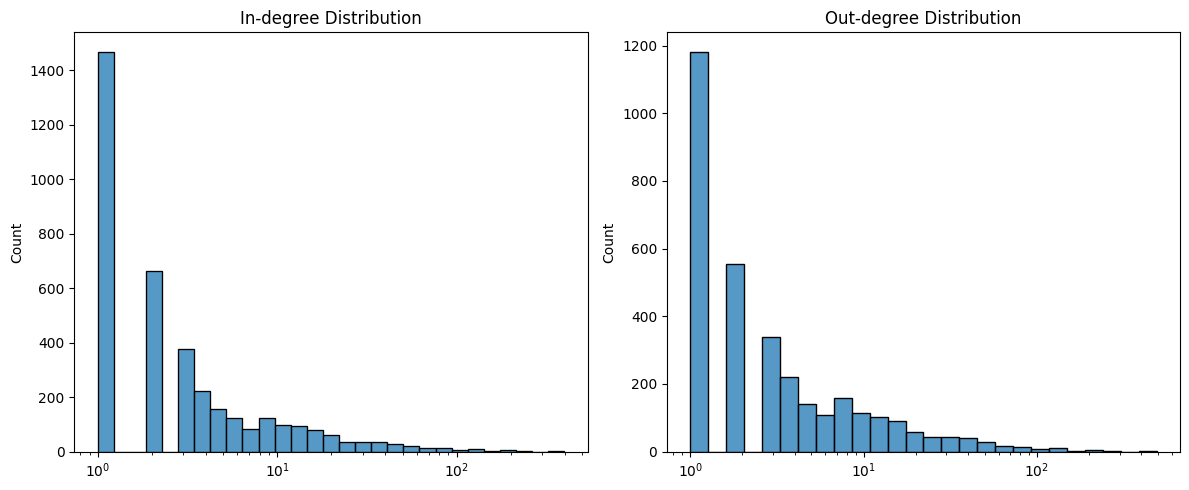

In [11]:
# In-degree and out-degree distributions
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(in_degrees, log_scale=True)
plt.title('In-degree Distribution')
plt.subplot(122)
sns.histplot(out_degrees, log_scale=True)
plt.title('Out-degree Distribution')
plt.tight_layout()

2.2 Node Trust Analysis:

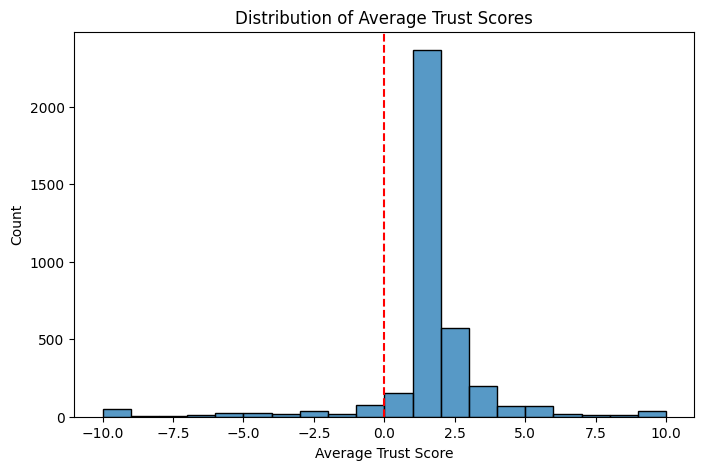

In [12]:
# Trust analysis for nodes
node_trust = {}
for node in G.nodes():
    incoming_ratings = [d['weight'] for _, _, d in G.in_edges(node, data=True)]
    if incoming_ratings:
        avg_trust = sum(incoming_ratings) / len(incoming_ratings)
        node_trust[node] = avg_trust
    else:
        node_trust[node] = 0

# Visualize distribution of average trust scores
plt.figure(figsize=(8, 5))
sns.histplot(list(node_trust.values()), bins=20)
plt.title('Distribution of Average Trust Scores')
plt.xlabel('Average Trust Score')
plt.axvline(x=0, color='r', linestyle='--')

2.3 Centrality Analysis:



In [29]:
# Calculate signed centrality measures on the largest SCC
largest_scc = max(nx.strongly_connected_components(G), key=len)
Gs = G.subgraph(largest_scc).copy()
Gp = nx.DiGraph(((u, v, {"w": d["weight"]}) for u,v,d in Gs.edges(data=True) if d["weight"] > 0))
Gn = nx.DiGraph(((u, v, {"w": abs(d["weight"])}) for u,v,d in Gs.edges(data=True) if d["weight"] < 0))


## Signed pagerank
pr_pos = nx.pagerank(Gp, weight="w")
pr_neg = nx.pagerank(Gn, weight="w")

signed_pr = {n: pr_pos.get(n, 0) - pr_neg.get(n, 0)
               for n in set(pr_pos) | set(pr_neg)}

# Signed Betweenness Centrality - without weights for speed
bc_pos = nx.betweenness_centrality(Gp, weight=None, normalized=True)
bc_neg = nx.betweenness_centrality(Gn, weight=None, normalized=True)

signed_bc = {n: bc_pos.get(n, 0.0) - bc_neg.get(n, 0.0)
             for n in set(bc_pos) | set(bc_neg)}

top_pagerank    = sorted(signed_pr.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness = sorted(signed_bc.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes by *Signed* PageRank:")
for node, score in top_pagerank:
    print(f"Node {node:<8}: {score: .6f}")

print("\nTop 10 nodes by *Signed* Betweenness:")
for node, score in top_betweenness:
    print(f"Node {node:<8}: {score: .6f}")

Top 10 nodes by *Signed* PageRank:
Node 1       :  0.018161
Node 2       :  0.012533
Node 4       :  0.012160
Node 3       :  0.010333
Node 6       :  0.006344
Node 5       :  0.006148
Node 10      :  0.004972
Node 8       :  0.004906
Node 16      :  0.004858
Node 18      :  0.004588

Top 10 nodes by *Signed* Betweenness:
Node 1       :  0.172559
Node 2       :  0.078494
Node 4       :  0.074244
Node 3       :  0.060381
Node 10      :  0.050407
Node 11      :  0.041203
Node 13      :  0.038335
Node 5       :  0.034627
Node 6       :  0.031931
Node 33      :  0.031201


In [48]:
graphs = {"Positive (trust)": Gp, "Negative (distrust)": Gn}

def inv_len(g):
    """returns dictionary {(u,v): 1/w} for distance"""
    return {(u, v): 1.0 / d["w"] for u, v, d in g.edges(data=True)}

def top(dic, k=10):
    return sorted(dic.items(), key=lambda x: x[1], reverse=True)[:k]

for name, H in graphs.items():
    print(f"\n=== {name} subgraph ===")

    n = len(H)
    if n < 2:
        print("  (not enough nodes)")
        continue

    dist_attr = "len"
    nx.set_edge_attributes(H, inv_len(H), dist_attr)

    # centrality measures
    strength = dict(H.degree(weight="w"))
    deg_c    = nx.degree_centrality(H)
    in_deg_c = {u: d/(n-1) for u, d in H.in_degree()}
    out_deg_c= {u: d/(n-1) for u, d in H.out_degree()}
    close    = nx.closeness_centrality(H, distance=dist_attr)

    # Katz
    lam_max  = max(np.linalg.eigvals(nx.adjacency_matrix(H, weight="w").toarray())).real
    alpha    = 0.85 / lam_max
    katz     = nx.katz_centrality_numpy(H, alpha=alpha, beta=1.0, weight="w")

    # communicability
    C = nx.communicability_exp(H.to_undirected())
    comm = {u: sum(row.values()) - 1.0 for u, row in C.items()}

    metrics = {
        "Strength (weighted degree)": strength,
        "Degree centrality":          deg_c,
        "In-degree centrality":       in_deg_c,
        "Out-degree centrality":      out_deg_c,
        "Closeness centrality":       close,
        "Katz centrality":            katz,
        "Communicability centrality": comm,
    }

    for mname, scores in metrics.items():
        print(f"\nTop-10 by {mname}:")
        for u, s in top(scores):
            print(f"  {u:<8} {s:.6f}")


=== Positive (trust) subgraph ===

Top-10 by Strength (weighted degree):
  1        1274.000000
  2        1188.000000
  3        1111.000000
  4        1071.000000
  177      785.000000
  7        781.000000
  11       739.000000
  5        706.000000
  6        680.000000
  9        611.000000

Top-10 by Degree centrality:
  1        0.250620
  3        0.151177
  4        0.124845
  2        0.119269
  11       0.111524
  7        0.108426
  177      0.103779
  10       0.100991
  6        0.085812
  5        0.084882

Top-10 by In-degree centrality:
  1        0.122986
  3        0.077447
  2        0.063507
  4        0.062268
  7        0.057311
  11       0.056691
  10       0.050496
  177      0.048327
  5        0.044610
  6        0.043061

Top-10 by Out-degree centrality:
  1        0.127633
  3        0.073730
  4        0.062577
  2        0.055762
  177      0.055452
  11       0.054833
  7        0.051115
  10       0.050496
  6        0.042751
  22       0.040582

Top-

### 3. Macroscale Analysis


3.1 Clustering:


Average clustering coefficient: 0.1671


Text(0.5, 1.0, 'Distribution of Clustering Coefficients')

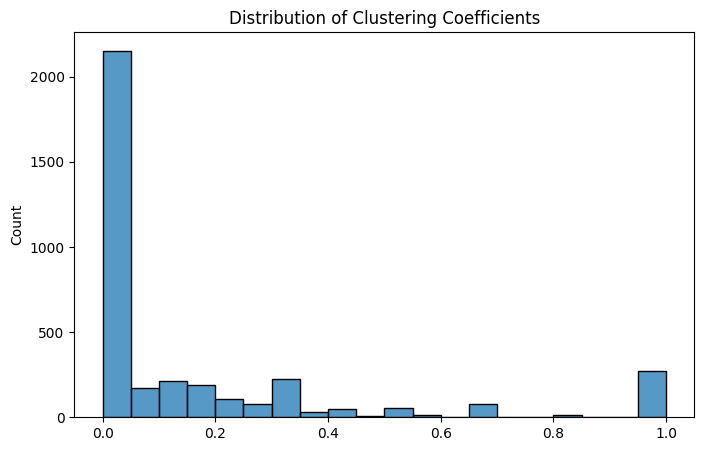

In [16]:
# Create undirected version for clustering analysis (consider only positive edges)
G_undirected = nx.Graph()
for u, v, d in G.edges(data=True):
    if d['weight'] > 0:  # Only consider positive edges
        G_undirected.add_edge(u, v)

# Calculate clustering coefficients
clustering = nx.clustering(G_undirected)
avg_clustering = sum(clustering.values()) / len(clustering)
print(f"Average clustering coefficient: {avg_clustering:.4f}")

plt.figure(figsize=(8, 5))
sns.histplot(list(clustering.values()), bins=20)
plt.title('Distribution of Clustering Coefficients')

In [57]:
# ---------- 1. Triangles (per node and total) ----------------------------
triangles_per_node = nx.triangles(G_undirected)   # dict {u: #Δ around u}
n_triangles = sum(triangles_per_node.values()) // 3
print(f"Total number of triangles: {n_triangles}")

# ---------- 2. Transitivity (global clustering coefficient) --------------
trans = nx.transitivity(G_undirected)             # 3*Δ / #connected triples
print(f"Transitivity (global C): {trans:.4f}")

# ---------- 3. Small-world metrics: Watts–Strogatz sigma & Telesford omega
#  sigma  = (C / C_rand) / (L / L_rand)           — Humphries & Gurney (2008)
#  omega  = (L_rand / L) - (C / C_latt)           — Telesford (2011)

C = avg_clustering                                  # clustering of original graph

# --- characteristic path length of the largest connected component
UG = G.to_undirected()
largest_cc = max(nx.connected_components(UG), key=len)
H = UG.subgraph(largest_cc).copy()
L = nx.average_shortest_path_length(H)

# --- random graph with the same N and M
Gr = nx.gnm_random_graph(
        G_undirected.number_of_nodes(),
        G_undirected.number_of_edges(),
        seed=42
)
Cr = nx.average_clustering(Gr)

largest_cc_gr = max(nx.connected_components(Gr), key=len)
Hr = Gr.subgraph(largest_cc_gr).copy()
Lr = nx.average_shortest_path_length(Hr)

sigma_val = (C / Cr) / (L / Lr)
print(f"Small-world sigma (manual): {sigma_val:.3f}")


Total number of triangles: 18219
Transitivity (global C): 0.0760
Small-world sigma (manual): 103.853


3.2 Component Analysis:
~

In [49]:
# Analyze strongly connected components in the directed graph
strongly_connected = list(nx.strongly_connected_components(G))
print(f"Number of strongly connected components: {len(strongly_connected)}")
print(f"Size of largest strongly connected component: {len(largest_scc)}")

# Analyze weakly connected components
weakly_connected = list(nx.weakly_connected_components(G))
largest_wcc = max(nx.weakly_connected_components(G), key=len)
print(f"Number of weakly connected components: {len(weakly_connected)}")
print(f"Size of largest weakly connected component: {len(largest_wcc)}")

Number of strongly connected components: 540
Size of largest strongly connected component: 3235
Number of weakly connected components: 5
Size of largest weakly connected component: 3775


3.3 Path Length Analysis/shortest path



In [19]:
# 3.3.1. Calculate average shortest path of undirected graph
UG = G.to_undirected()
largest_cc = max(nx.connected_components(UG), key=len)
H = UG.subgraph(largest_cc).copy()

apl_lcc = nx.average_shortest_path_length(H)
print(f"Average path length (largest connected component): {apl_lcc:.4f}")


Average path length (largest connected component): 3.5708


In [17]:
# Create largest strongly connected component subgraph for path analysis
largest_scc = G.subgraph(strongly_connected[0])
path_lengths = dict(nx.all_pairs_shortest_path_length(largest_scc))

# Calculate average path length
total_paths = 0
sum_path_lengths = 0
for source in path_lengths:
    for target in path_lengths[source]:
        if source != target:
            sum_path_lengths += path_lengths[source][target]
            total_paths += 1

avg_path_length = sum_path_lengths / total_paths if total_paths > 0 else 0
print(f"Average shortest path length in largest SCC: {avg_path_length:.4f}")

Average shortest path length in largest SCC: 0.0000


In [58]:
l_scc = max(nx.strongly_connected_components(G), key=len)
Gs = G.subgraph(l_scc).copy()
import networkx as nx

# --- 1. split Gs into trust (+) and distrust (–) subgraphs --------------
G_pos = nx.DiGraph(((u, v, d) for u, v, d in Gs.edges(data=True)
                    if d["weight"] > 0))          # positive weights only
G_neg_raw = nx.DiGraph(((u, v, d) for u, v, d in Gs.edges(data=True)
                        if d["weight"] < 0))      # negative weights only

# --- 2. keep the largest SCC inside each subgraph -----------------------
pos_scc_nodes = max(nx.strongly_connected_components(G_pos), key=len)
Gp = G_pos.subgraph(pos_scc_nodes).copy()

neg_scc_nodes = max(nx.strongly_connected_components(G_neg_raw), key=len)
Gn_raw = G_neg_raw.subgraph(neg_scc_nodes).copy()

# --- 3. APL on the positive SCC (weights are already ≥0) ----------------
apl_pos = nx.average_shortest_path_length(Gp, weight="weight")
print(f"Average path length (positive SCC, weighted): {apl_pos:.4f}")

# --- 4. APL on the negative SCC  ----------------------------------------
#      Dijkstra cannot handle negative weights, so we:
#        a) take absolute values as edge lengths  (|−w|  =  1…10)
#        b) OR ignore weights altogether and measure hops
for u, v, d in Gn_raw.edges(data=True):
    d["abs_w"] = abs(d["weight"])        # length ≥ 1

apl_neg_abs = nx.average_shortest_path_length(Gn_raw, weight="abs_w")
apl_neg_hop = nx.average_shortest_path_length(Gn_raw)                  # unweighted

print(f"Average path length (negative SCC, |weight| as cost): {apl_neg_abs:.4f}")
print(f"Average path length (negative SCC, hops only):        {apl_neg_hop:.4f}")


Average path length (positive SCC, weighted): 5.1530
Average path length (negative SCC, |weight| as cost): 20.0043
Average path length (negative SCC, hops only):        3.7548


3.4 Community Detection:



Number of communities detected: 54
Size of largest community: 1058


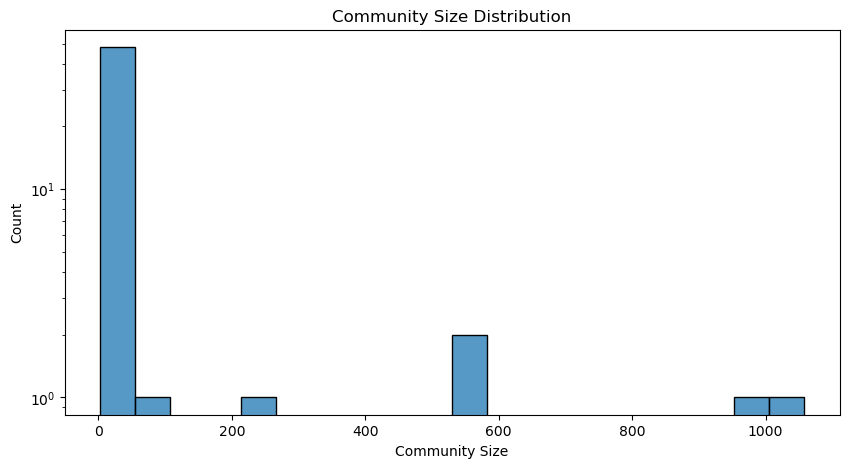

In [ ]:
# Only use positive edges for community detection
G_positive = nx.Graph()
for u, v, d in G.edges(data=True):
    if d['weight'] > 0:
        G_positive.add_edge(u, v)

# Apply community detection
communities = nx.community.greedy_modularity_communities(G_positive)
print(f"Number of communities detected: {len(communities)}")
print(f"Size of largest community: {len(communities[0])}")

# Distribution of community sizes
community_sizes = [len(c) for c in communities]
plt.figure(figsize=(10, 5))
sns.histplot(community_sizes, bins=20)
plt.title('Community Size Distribution')
plt.xlabel('Community Size')
plt.yscale('log')

In [53]:
# Newman coefficient
from networkx.algorithms.community import \
     greedy_modularity_communities, modularity

Q = modularity(G_undirected, communities, weight=None)
print(f"Newman–Girvan modularity Q: {Q:.4f}")

Newman–Girvan modularity Q: 0.4378


Number of communities detected: 57
Size of largest community: 117


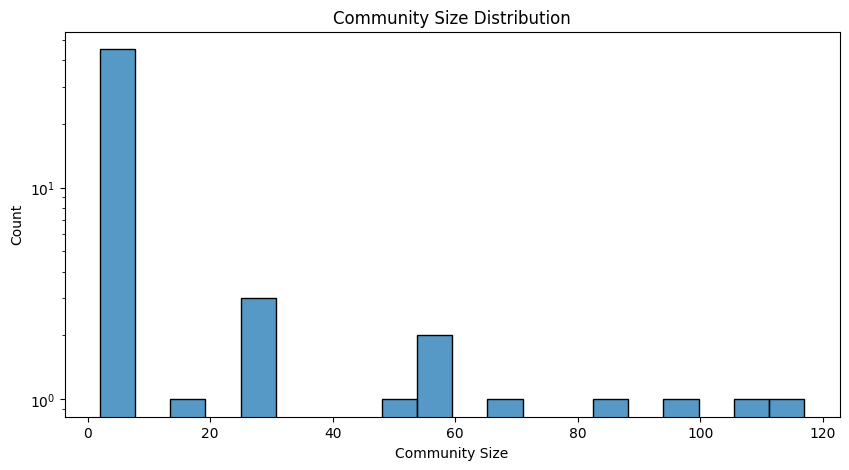

In [59]:
# Only use negative edges for community detection
G_neg = nx.Graph()
for u, v, d in G.edges(data=True):
    if d['weight'] < 0:
        G_neg.add_edge(u, v)

# Apply community detection
communities = nx.community.greedy_modularity_communities(G_neg)
print(f"Number of communities detected: {len(communities)}")
print(f"Size of largest community: {len(communities[0])}")

# Distribution of community sizes
community_sizes = [len(c) for c in communities]
plt.figure(figsize=(10, 5))
sns.histplot(community_sizes, bins=20)
plt.title('Community Size Distribution')
plt.xlabel('Community Size')
plt.yscale('log')

In [61]:
# Newman coefficient
from networkx.algorithms.community import \
     greedy_modularity_communities, modularity

Q = modularity(G_neg, communities, weight=None)
print(f"Newman–Girvan modularity Q: {Q:.4f}")

Newman–Girvan modularity Q: 0.6058


3.5 Trust vs Distrust Analysis:



In [ ]:
# Analyze trust and distrust patterns between communities
community_dict = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = i

# Only consider edges between nodes that are in communities
inter_community_edges = []
for u, v, d in G.edges(data=True):
    if u in community_dict and v in community_dict:
        source_comm = community_dict[u]
        target_comm = community_dict[v]
        inter_community_edges.append((source_comm, target_comm, d['weight']))

# Count positive and negative edges within and between communities
same_comm_pos = 0
same_comm_neg = 0
diff_comm_pos = 0
diff_comm_neg = 0

for s_comm, t_comm, weight in inter_community_edges:
    if s_comm == t_comm:  # Same community
        if weight > 0:
            same_comm_pos += 1
        else:
            same_comm_neg += 1
    else:  # Different communities
        if weight > 0:
            diff_comm_pos += 1
        else:
            diff_comm_neg += 1

print(f"Same community positive edges: {same_comm_pos}")
print(f"Same community negative edges: {same_comm_neg}")
print(f"Different community positive edges: {diff_comm_pos}")
print(f"Different community negative edges: {diff_comm_neg}")

Same community positive edges: 16153
Same community negative edges: 723
Different community positive edges: 6497
Different community negative edges: 666
